# Basic Autoencoder

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [44]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

train_loader = torch.utils.data.DataLoader(mnist_train,batch_size=batch_size, shuffle=True,num_workers=2,drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test,batch_size=batch_size, shuffle=False,num_workers=2,drop_last=True)

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(28*28, 20)
        self.decoder = nn.Linear(20, 28*28)
        
    def forward(self, x):
        x = x.view(batch_size, -1)
        encoded = self.encoder(x)
        out = self.decoder(encoded).view(batch_size, 1, 28, 28)
    
        return out

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

loss_arr = []
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):  # label will not be use because autoencoder is unsupervised learning
        x = image.to(device)
        optimizer.zero_grad()
        output = model.forward(x)
        loss = loss_func(output, x)
        loss.backward()
        optimizer.step()
        
    if j % 1000 == 0 :
        print(loss)
        loss_arr.append(loss.cpu().data.numpy()[0])

cuda:0


torch.Size([256, 28, 28])


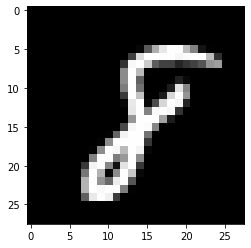

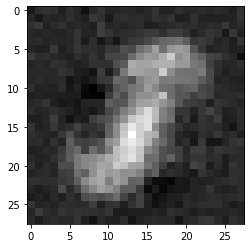

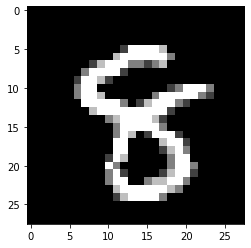

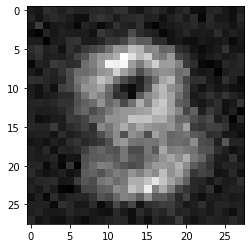

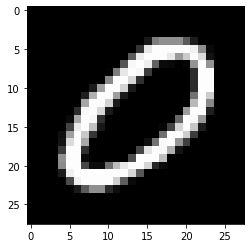

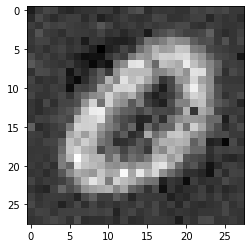

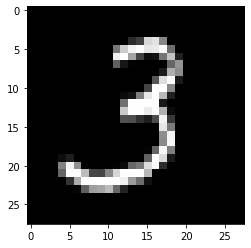

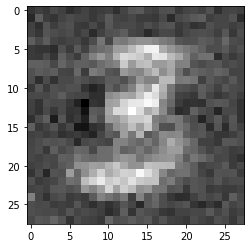

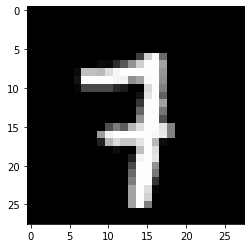

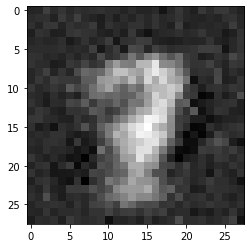

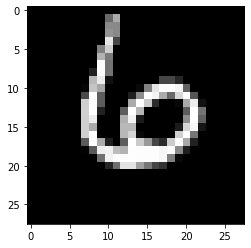

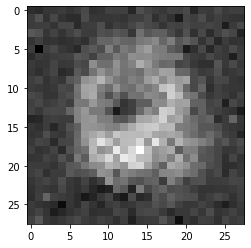

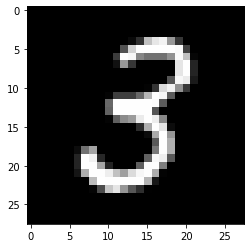

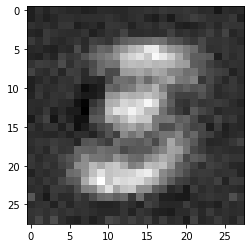

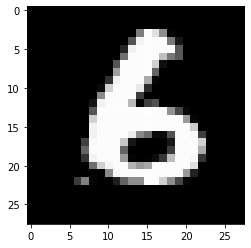

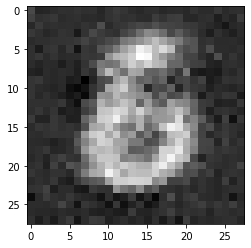

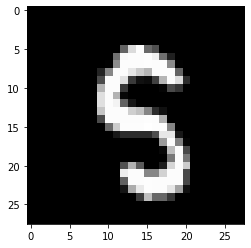

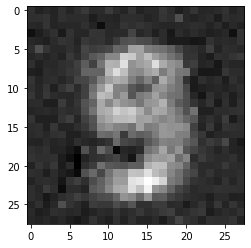

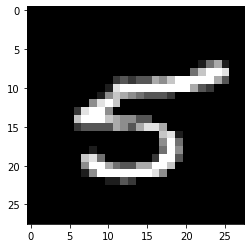

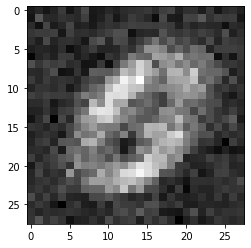

In [25]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
    plt.imshow(torch.squeeze(image[i]).numpy(), cmap = 'gray')
    plt.show()
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()

# Convolution Autoencoder

In [46]:
# import modules, set hyperparameters and load datasets are same as before
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(1, 16, 3, padding = 1),  # batch x 16 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.Conv2d(16, 32, 3, padding = 1),  # batch x 32 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32, 64, 3, padding = 1),  # batch x 64 x 28 x 28
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2, 2)  # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64, 128, 3, padding = 1),  # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2, 2),
                        nn.Conv2d(128, 256, 3, padding = 1),  # batch x 256 x 7 x 7
                        nn.ReLU()
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        
        return out
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),  # batch x 128 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),  # batch x 64 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,16,3,1,1),  # batch x 16 x 14 x 14
                        nn.ReLU(),
                        nn.BatchNorm2d(16),
                        nn.ConvTranspose2d(16,1,3,2,1,1),  # batch x 1 x 28 x 28
                        nn.ReLU()
        )
        
    def forward(self,x):
        out = x.view(batch_size,256,7,7)
        out = self.layer1(out)
        out = self.layer2(out)
        return out
    
device = torch.device("cuda:0" if torch.cuda.is_available() else cpu())
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = optim.Adam(parameters, lr = learning_rate)

try:
    encoder, decoer = torch.load('./model/conv_autoencoder.pkl')
    print("\n------model restored-----\n")
except:
    print("\n-----model not restored-----\n")
    pass

for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        output = encoder(image)
        output = decoder(output)
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()
        
        if j % 10 == 0:
            torch.save([encoder, decoder], './model/conv_autoencoder.pkl')
            print(loss)     

cuda:0

------model restored-----

tensor(0.8258, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.1486, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0908, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0694, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0562, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0477, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0421, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0363, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0336, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0296, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0274, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0249, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0229, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0220, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0203, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0196, device='cuda:0', grad_fn=<MseLossBackward>)
tensor(0.0182, device

torch.Size([256, 28, 28])


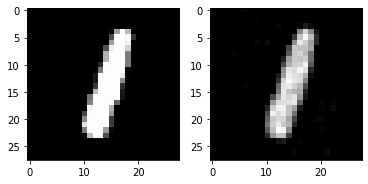

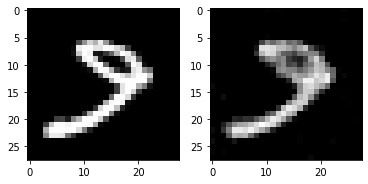

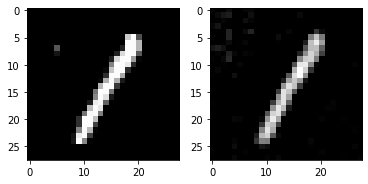

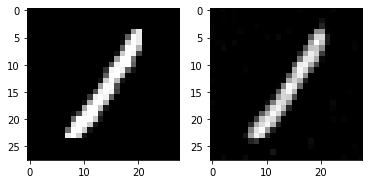

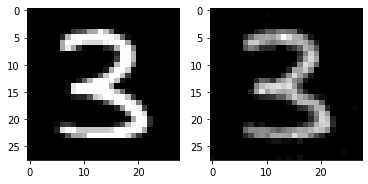

torch.Size([256, 28, 28])


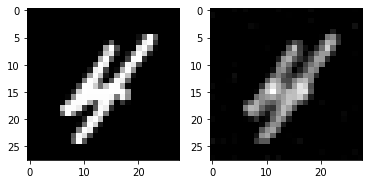

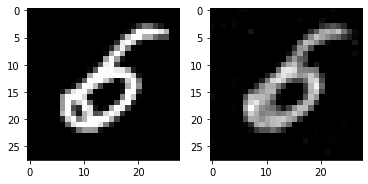

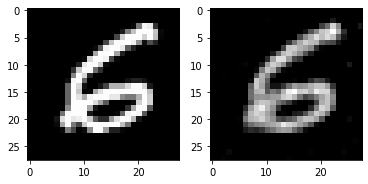

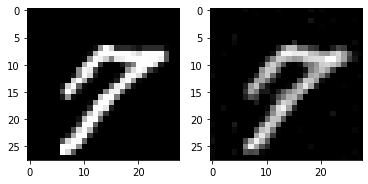

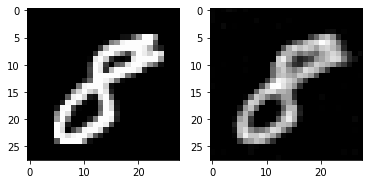

In [47]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(),cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(out_img[i].numpy(),cmap='gray')
    plt.show()
    
        
with torch.no_grad():
    for j,[image,label] in enumerate(test_loader):
       
        image = image.to(device)
        output = encoder(image)
        output = decoder(output)
        
    if j % 10 == 0:
        print(loss)       

out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(), cmap = 'gray')
    plt.subplot(1, 2, 2)
    plt.imshow(out_img[i].numpy(), cmap = 'gray')
    plt.show()
